<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/flow_matching_fmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install diffusers
!pip install tqdm
!pip install accelerate
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 72.7 

In [1]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
# import wandb
import time
import numpy

from pathlib import Path
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st

from datasets import load_dataset
from diffusers import UNet2DModel
from accelerate import Accelerator
from einops import rearrange

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2
from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

FMNIST_IN_CHANNELS = 1
FMNIST_OUT_CHANNELS = 1

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for fashion_mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fashion_mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
def _pre_conv(ni, nf, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d):
  layers = []
  if act: layers.append(act())
  if norm: layers.append(norm(ni))
  layers.append(nn.Conv2d(ni, nf, kernel_size, stride = stride, padding = kernel_size//2, bias = True))
  return nn.Sequential(*layers)

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = None):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

def get_log(n_steps = 1000, min = 0.0001, max = 0.02, x_start = 0.1 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.log(points), min = min, max = max)

class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

class HackDL():
  def __init__(self, dl, mult = 2):
    self.dl = dl
    self.mult = mult

  def __len__(self):
    return len(self.dl) * self.mult

  def __iter__(self):
    d = next(iter(self.dl))
    for i in range(self.mult):
      yield d


def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.5, p = 1.0), v2.RandomRotation(degrees=(0, 360))], p=0.8):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p = p)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

def get_model(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for i in range(1, len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class FID:
  def __init__(self, model = None, targ = None):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

In [ ]:
class SM:
  def forward(self, *args, **kwargs):
    self.saved = super().forward(*args, **kwargs)
    return self.saved

class SConv(SM, nn.Conv2d): pass
class SResBlock(SM, ResBlock): pass

class SelfAttention(nn.Module):
  def __init__(self, ni):
    super().__init__()
    self.kqv = nn.Linear(ni, 3*ni)
    self.norm = nn.GroupNorm(1, ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = ni

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      return rearrange(x, 'b c h w -> b (h w) c')
    if mode == 2:
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # Verify Shape
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return inp + x

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    ni = ni//n_heads
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    x = inp
    x = self.norm(x)
    x = self.rearrange(x)
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    x = self.proj(att_x)
    x = self.rearrange(x, 2)
    return x

class MultiHeadSelfAttentionV2(nn.Module):
  def __init__(self, ni, n_heads = 16):
    super().__init__()
    self.n_heads = n_heads
    self.norm = nn.GroupNorm(1, ni)
    self.kqv = nn.Linear(ni, 3*ni)
    self.proj = nn.Linear(ni, ni)
    self.scale = math.sqrt(ni/n_heads)

  def rearrange(self, x, mode = 1):
    if mode == 1:
      self.h, self.w = x.shape[-2], x.shape[-1]
      x = rearrange(x, 'b c h w -> b (h w) c')
      return rearrange(x, 'b s (c d) -> (b d) s c', d = self.n_heads)
    if mode == 2:
      x = rearrange(x, '(b d) s c -> b s (c d)', d = self.n_heads)
      return rearrange(x, 'b (h w) c -> b c h w', h = self.h, w = self.w)

  def forward(self, inp):
    # st()
    x = inp
    x = self.norm(x)

    h, w = x.shape[-2], x.shape[-1]

    x = rearrange(x, 'b c h w -> b (h w) c')
    k, q, v = self.kqv(x).chunk(3, dim = -1)
    k = rearrange(k, 'b s (c d) -> (b d) s c', d = self.n_heads)
    q = rearrange(q, 'b s (c d) -> (b d) s c', d = self.n_heads)
    v = rearrange(v, 'b s (c d) -> (b d) s c', d = self.n_heads)

    sim = k @ q.transpose(-1, -2)/self.scale
    sim = F.softmax(sim, dim= -1)
    att_x = sim @ v
    att_x = rearrange(att_x, '(b d) s c -> b s (c d)', d = self.n_heads)
    x = self.proj(att_x)
    out = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
    return out

class AttEmbResBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, kernel_size = 3, stride = 1, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.emb_proj = nn.Linear(n_emb, 2*nf)
    self.id_conv = nn.Conv2d(ni, nf, kernel_size = 1, stride = stride) if ni != nf else fc.noop
    self.conv1 = _pre_conv(ni, nf, kernel_size, 1, act, norm)
    self.conv2 = _pre_conv(nf, nf, kernel_size, stride, act, norm)
    if attn: self.attn = MultiHeadSelfAttentionV2(nf, 8)

  def forward(self, x, t_emb):
    res = self.conv1(x)
    t_emb = self.emb_proj(t_emb)[:, :, None, None]  # bs, 2*nf
    scale, shift = t_emb.chunk(2, dim = 1)
    res = res + res * scale + shift
    res = self.conv2(res)
    x = self.id_conv(x) + res
    if hasattr(self, 'attn'): x = x + self.attn(x)
    return x

class SAttEmbResBlock(SM, AttEmbResBlock): pass

class DownBlock(nn.Module):
  def __init__(self, ni, nf, n_emb, n_layers = 1, add_down = True, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.layers = nn.ModuleList([SAttEmbResBlock(ni if i == 0 else nf, nf, n_emb = n_emb, act = act, norm = norm, attn = attn) for i in range(n_layers)])
    self.f_layer = SConv(nf, nf, kernel_size = 3, stride = 2, padding = 1) if add_down == True else fc.noop

  def forward(self, x, t_emb):
    for layer in self.layers:
      x = layer(x, t_emb)
    return self.f_layer(x)

  def get_acts(self):
    acts = [l.saved for l in self.layers]
    if hasattr(self.f_layer, 'saved'): acts.append(self.f_layer.saved)
    return acts

def up_conv(ni, nf, kernel_size = 3):
  return nn.Sequential(nn.Upsample(scale_factor = 2), nn.Conv2d(ni, nf, stride = 1, kernel_size = kernel_size, padding = kernel_size//2))

class UpBlock(nn.Module):
  def __init__(self, ni, nf, prev_nf, n_emb, add_up = True, n_layers = 2, act = nn.SiLU, norm = nn.BatchNorm2d, attn = False):
    super().__init__()
    self.blocks = nn.ModuleList([])
    for i in range(n_layers):
      if i == 0: inc = ni + nf
      elif i == n_layers - 1: inc = prev_nf + nf
      else: inc = 2*nf
      self.blocks.append(AttEmbResBlock(inc, nf, n_emb = n_emb, act = act, norm = norm, attn = attn))

    self.up = up_conv(nf, nf) if add_up else nn.Identity()

  def forward(self, x, ups, t_emb):
    for block in self.blocks: x = block(torch.cat([ups.pop(), x], dim = 1), t_emb)
    return self.up(x)

class DiffusionUNET(nn.Module):
  def __init__(self, in_channels = FMNIST_IN_CHANNELS, out_channels = FMNIST_OUT_CHANNELS,
                                                    nfs = [64, 128, 256, 512], n_layers = 2, emb_dim = 16, attn_start = 2, n_classes = 10):
    super().__init__()
    self.emb_dim = emb_dim
    n_emb = nfs[0]*4
    self.emb_mlp = nn.Sequential(nn.Linear(emb_dim, n_emb, bias = True),
                                 nn.BatchNorm1d(n_emb),
                                 nn.Linear(n_emb, n_emb, bias = True))

    self.c_emb = nn.Embedding(n_classes, n_emb)

    self.first_c = nn.Conv2d(in_channels, nfs[0], kernel_size = 3, padding = 1, bias = True)
    downs, ni = [], nfs[0]
    for i, nf in enumerate(nfs):
      downs.append(DownBlock(ni, nf, n_emb = n_emb, n_layers = n_layers, add_down = False if i == (len(nfs)-1) else True, attn = True if i >= attn_start else False))
      ni = nf

    self.downs = nn.Sequential(*downs)

    cross = [AttEmbResBlock(nfs[0], nfs[0], n_emb = n_emb, attn = False)]
    for i, cnf in enumerate(nfs):
      cross += [AttEmbResBlock(cnf, cnf, n_emb = n_emb, attn = True if i >= attn_start else False) for j in range(n_layers + 1 if i < len(nfs) - 1 else n_layers)]
    self.cross = nn.ModuleList(cross)

    self.mid_c = AttEmbResBlock(nf, nf, n_emb = n_emb, attn = True)

    ups, ni, nfs  = [], nfs[-1], list(reversed(nfs))
    for i, nf in enumerate(nfs):
      prev_nf = nfs[i + 1] if i < len(nfs) - 1 else nfs[i]
      ups.append(UpBlock(ni, nf, prev_nf, n_emb = n_emb, add_up = True if i < len(nfs) - 1 else False, n_layers = n_layers + 1, attn = True if i <= attn_start else False))
      ni = nf
    self.ups = nn.ModuleList(ups)
    self.final_c = _pre_conv(nfs[-1], out_channels) # EmbResBlock(nf, nf, n_emb = n_emb)

  def forward(self, inp):
    x, ts, ys = inp

    tembs = get_tembs(ts, self.emb_dim).to(x.device)

    t_emb = self.emb_mlp(tembs) # bs, 4*nfs[0]
    c_emb = self.c_emb(ys)
    emb = t_emb + c_emb
    x = self.first_c(x)
    acts = [x]
    for block in self.downs:
      x = block(x, emb)
    x = self.mid_c(x, emb)
    # acts += [i.saved for j in self.downs for i in j]
    for i in self.downs: acts += i.get_acts()
    n_acts = [cr(act, emb) for cr, act in zip(self.cross, acts)]
    for up in self.ups: x = up(x, n_acts, emb)
    return self.final_c(x)


In [ ]:
# Flow Matching Forward - Conditional Flow Matching
def pad_like(src: torch.tensor, target: torch.tensor, dim = 0) -> torch.tensor:

  '''

  This functions pads the src tensor in way that can be used to do tensor arithmetic on target tensor keeping the src tensors dim constant.

  Args:
    src: one dimension tensor
    target: the target tensor to which shape the src tensor has to be made compatible
    dim: dimension to keep constant

  Returns:
    padded src tensor

  '''
  shape = target.shape
  idx = [1]*(len(shape))
  idx[dim] = -1
  return src.view(*idx)

class CFM(Callback):

  '''
    Conditional Flow Matching Class
  '''

  def __init__(self, sigma = 0.0): self.sigma = sigma

  def before_batch(self, learn: Learner) -> tuple:

    '''
    This functions preprocesses the data - Applies CFM schedule transformations to x and calculates xt, t and out(Models target - Vector Field)

      t = Any Random Number between 0 and 1 - Specifying the time in the probability density path.

      xt = mean + variance
      mean = t*x1 + (1 - t)*x0
      variance = torch.randn_like(x1) * sigma

      ut - Vector Field = x1 - x0


    Args:
      learner: Learner object

    Returns:
      tuple consisting of xt (Intermediate state between signal and noise), t (The level at which signal is destroyed), y (Class Label of what the image is)
      out -> Vecotr Field (Essential target for the model to predict)


    '''

    x1, y = learn.batch
    x0 = torch.randn_like(x1).to(x1.device)
    eps = torch.randn_like(x1).to(x1.device)

    t = pad_like(torch.rand(x1.shape[0], device = x1.device), x1, dim = 0)
    mean = t*x1 + (1 - t)*x0
    var = eps * self.sigma
    xt = mean + var

    # Calculate Vector Field
    ut = x1 - x0

    learn.batch = (xt, t.squeeze(), y), ut

In [ ]:
def flatten_mse(yhat, targ): return F.mse_loss(yhat.flatten(), targ.flatten())

def get_tembs(t_points = None, nemb = 32, max_steps = 10000):

    # Sinusoidal Embeddings for timesteps.

    tsteps = t_points * 2. - 1. if t_points != None else torch.linspace(-10, 10, max_steps)

    points = -1*math.log(max_steps) * torch.linspace(0, 1, nemb//2)
    points = points.to(t_points.device)
    points_dist = tsteps[:, None] * points[None, :].exp()
    return torch.cat((torch.sin(points_dist), torch.cos(points_dist)), dim = 1)

loss,epoch,train
0.244,0,train
0.131,0,eval
0.111,1,train
0.106,1,eval
0.097,2,train
0.104,2,eval
0.091,3,train
0.094,3,eval
0.087,4,train
0.089,4,eval


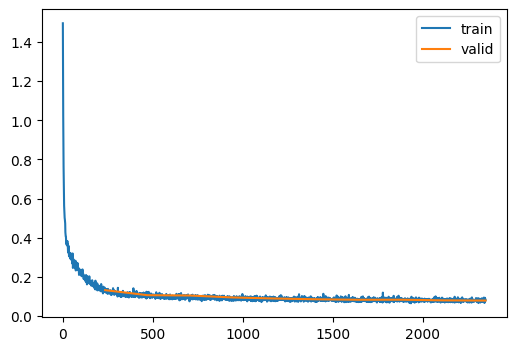

In [21]:
lr_max, epochs = 2e-03, 10
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          CFM(sigma = 0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = flatten_mse, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [22]:
torch.save(learner.model, mdl_path/'flow_matching_v1.pkl')

In [ ]:
def combined_loss(yhat, target):

    lamb = 0.6
    bs = yhat.shape[0]
    target = torch.ones(bs).to(yhat.device)

    return lamb * flatten_mse(yhat, target) + F.cosine_embedding_loss(yhat.view(bs, -1), target.view(bs, -1), target) * (1-lamb)


In [ ]:
lr_max, epochs = 2e-03, 6
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          CFM(sigma = 0.01),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  DiffusionUNET(nfs = [64, 128, 256, 512])
learner = AccLearner(model, dls, loss_func = combined_loss, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [ ]:
# combined loss
torch.save(learner.model, mdl_path/'flow_matching_v2.pkl')